In [11]:
# Radial Based Function Network
# CS552: Data Science with Python
# Tayyab Azhar Shah

In [12]:
# import

import numpy as np

In [13]:
# define standardization for use in the RBF network (training only)

class StandardScaler:
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)
        self.std_[self.std_ == 0] = 1.0
        return self

    def transform(self, X):
        return (X - self.mean_) / self.std_

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


In [14]:
# Euclidean distance helper

def pairwise_squared_distances(X, C):
    X_norm = np.sum(X**2, axis=1, keepdims=True)
    C_norm = np.sum(C**2, axis=1)
    return X_norm + C_norm - 2 * X @ C.T


In [15]:
# K-means for learning RBF centers (training only)

class KMeans:
    def __init__(self, n_clusters, max_iter=100, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def fit(self, X):
        rng = np.random.default_rng(self.random_state)
        indices = rng.choice(len(X), self.n_clusters, replace=False)
        centers = X[indices]

        for _ in range(self.max_iter):
            dists = pairwise_squared_distances(X, centers)
            labels = np.argmin(dists, axis=1)

            new_centers = np.array([
                X[labels == k].mean(axis=0) if np.any(labels == k) else centers[k]
                for k in range(self.n_clusters)])

            if np.linalg.norm(new_centers - centers) < self.tol:
                break

            centers = new_centers

        self.centers_ = centers
        return self


In [16]:
# feature mapping from ınputs to RBF feature space (training and test)

def rbf_kernel(X, centers, sigma):
    sq_dists = pairwise_squared_distances(X, centers)
    return np.exp(-sq_dists / (2 * sigma**2))


In [17]:
# sigma value estımations from training centers

def estimate_sigma(centers):
    dists = pairwise_squared_distances(centers, centers)
    np.fill_diagonal(dists, np.inf)
    nearest = np.min(dists, axis=1)
    return np.sqrt(np.mean(nearest))


In [18]:
# ridge-regularized least squares method for weight estımatıon

def ridge_regression(Phi, Y, lam):
    M = Phi.shape[1]
    A = Phi.T @ Phi + lam * np.eye(M)
    B = Phi.T @ Y
    return np.linalg.solve(A, B)


In [28]:
# RBF main block

class RBFNetwork:
    def __init__(self, n_centers, sigma="auto", lam=1e-3,  random_state=None):
        self.n_centers = n_centers
        self.sigma = sigma
        self.lam = lam
        self.random_state = random_state

    def _rbf(self, X):
        dists = np.linalg.norm(X[:, None, :] - self.centers[None, :, :], axis=2)
        return np.exp(-(dists ** 2) / (2 * self.sigma ** 2))

    def fit(self, X, y):
        # k-means centers (training data only)
        kmeans = KMeans(n_clusters=self.n_centers, random_state=42)
        kmeans.fit(X)
        self.centers = kmeans.centers_

        # automatic sigma
        if self.sigma == "auto":
            dists = np.linalg.norm(self.centers[:, None, :] - self.centers[None, :, :], axis=2)
            self.sigma = np.mean(dists[dists > 0])

        # design matrix
        Phi = self._rbf(X)
        Phi = np.hstack([Phi, np.ones((Phi.shape[0], 1))])  # bias

        # ridge regression
        I = np.eye(Phi.shape[1])
        self.weights = np.linalg.solve(Phi.T @ Phi + self.lam * I,Phi.T @ y)

    def predict(self, X):
        Phi = self._rbf(X)
        Phi = np.hstack([Phi, np.ones((Phi.shape[0], 1))])
        return Phi @ self.weights


In [29]:
# network test (debugging)
# testınf ıf the pıpelıne works
# scaling -> k-means -> sigma est -> RBF features -> ridge reg -> prediction
# expected outcome: low MSE value

np.random.seed(0)
X = np.random.uniform(-1, 1, (200, 2))
Y = np.sin(X[:, [0]]) + np.cos(X[:, [1]])

model = RBFNetwork(n_centers=20, sigma="auto", lam=1e-3, random_state=0)
model.fit(X[:150], Y[:150])
preds = model.predict(X[150:])

mse = np.mean((preds - Y[150:])**2)
print("Test MSE:", mse)


Test MSE: 0.00012566763306536043


Small  | Train MSE: 116.187 | Test MSE: 112.185
Medium | Train MSE: 76.692 | Test MSE: 80.645
Deep   | Train MSE: 42.641 | Test MSE: 54.552


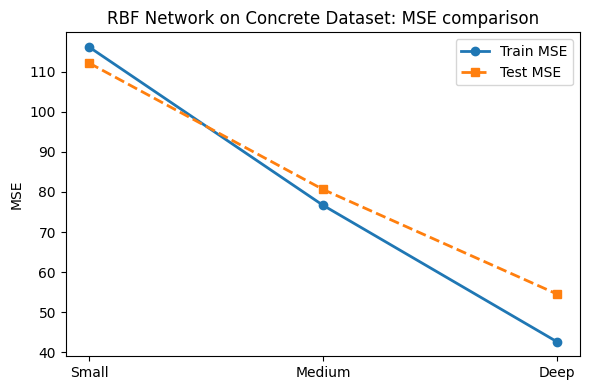

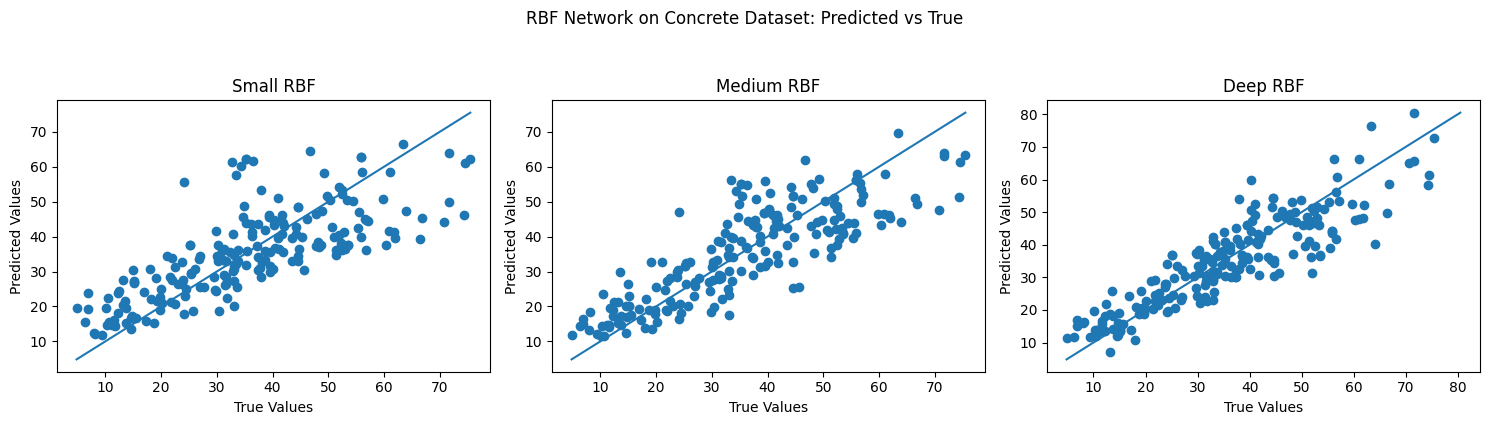

In [44]:
# ML experiment
# we use UCI Concrete Strength dataset

#imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# load dataset

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
df = pd.read_excel(url)

X = df.iloc[:, :-1].values   # 8 features
y = df.iloc[:, -1].values.reshape(-1, 1)  # target

# train-test split: 80-20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# feature scaling

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 3 modes for testıng algorıthm: Small, Medium, Deep

configs = {"Small": 20,
          "Medium": 50,
          "Deep": 100}

results = {}

# RBF algorithm using our defined function

models = {}
predictions = {}

for name, n_centers in configs.items():
    model = RBFNetwork(n_centers=n_centers,sigma="auto",lam=1e-3,random_state=42)

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    models[name] = model
    predictions[name] = y_test_pred

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    results[name] = (train_mse, test_mse)

    print(f"{name:6s} | Train MSE: {train_mse:.3f} | Test MSE: {test_mse:.3f}")


# results

#MSE graphs
labels = list(results.keys())
train_mse = [results[k][0] for k in labels]
test_mse  = [results[k][1] for k in labels]
x = np.arange(len(labels))
plt.figure(figsize=(6, 4))
plt.plot(x, train_mse, marker="o", linewidth=2, label="Train MSE")
plt.plot(x, test_mse, marker="s", linewidth=2, linestyle="--", label="Test MSE")

plt.xticks(x, labels)
plt.ylabel("MSE")
plt.title("RBF Network on Concrete Dataset: MSE comparison")
plt.legend()
plt.tight_layout()
plt.show()


#Scatter plot
plt.figure(figsize=(15, 4))

for i, name in enumerate(configs.keys(), 1):
    y_pred = predictions[name]

    plt.subplot(1, 3, i)
    plt.scatter(y_test, y_pred)

    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val])

    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{name} RBF")

plt.suptitle("RBF Network on Concrete Dataset: Predicted vs True", y=1.05)
plt.tight_layout()
plt.show()

